In [1]:
#%matplotlib notebook

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from livelossplot import PlotLosses

In [3]:
# Training settings
batch_size = 256
test_batch_size = 1000
num_epochs = 12
lr = 0.01
momentum = 0.5
seed = 1
no_cuda = False
save_model = False

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 8, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../../data', train=True, download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        '../../data', train=False, download=True,
        transform=transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)


dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

In [6]:
device = torch.device('cuda:0' if use_cuda else 'cpu')

model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

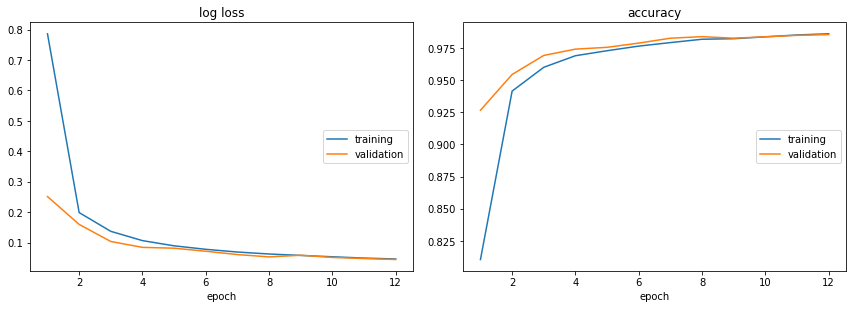

log loss:
training   (min:    0.046, max:    0.786, cur:    0.046)
validation (min:    0.045, max:    0.251, cur:    0.045)

accuracy:
training   (min:    0.810, max:    0.986, cur:    0.986)
validation (min:    0.927, max:    0.985, cur:    0.985)


In [7]:
liveloss = PlotLosses()
model = model.to(device)

for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if model.training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

        prefix = ''
        if not model.training:
            prefix = 'val_'

        logs[prefix + 'log loss'] = epoch_loss.item()
        logs[prefix + 'accuracy'] = epoch_acc.item()

    liveloss.update(logs)
    liveloss.draw()